<a href="https://colab.research.google.com/github/rpatwardhan7/Recorrupted-to-Recorrupted-Image-Denoising/blob/main/AWGN_Removal_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWGN Removal Experiment on BSD

In [ ]:
!git clone https://github.com/cszn/DnCNN.git

Cloning into 'DnCNN'...
remote: Enumerating objects: 946, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 946 (delta 6), reused 0 (delta 0), pack-reused 934
Receiving objects: 100% (946/946), 127.72 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [ ]:
!git clone https://github.com/clausmichele/CBSD68-dataset.git

Cloning into 'CBSD68-dataset'...
remote: Enumerating objects: 564, done.
remote: Total 564 (delta 0), reused 0 (delta 0), pack-reused 564
Receiving objects: 100% (564/564), 181.30 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import os
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Collect data

In [ ]:
data_path = '/content/DnCNN/TrainingCodes/DnCNN_TrainingCodes_v1.0/data/Train400' 
training_imgs_list = os.listdir(data_path)

N = 400
H, W = 180, 180

clean_images = torch.zeros(N, H, W)

for i, img_name in enumerate(training_imgs_list):
    full_img_path = data_path + '/' + img_name
    img = cv2.imread(full_img_path, 0) / 255.0
    clean_images[i] = torch.from_numpy(img)

#cv2_imshow(clean_images[16].numpy() * 255.0)

## AWGN dataset generation

In [ ]:
NOISE_LEVEL = 25
y_tensor = torch.zeros(N, H, W)
for i in range(N):
    x = clean_images[i]
    noise = torch.randn(x.size()).mul_(NOISE_LEVEL/255.0)
    y_tensor[i] = x + noise
#cv2_imshow(y_tensor[16].numpy() * 255.0)

## Recorruption 
In this section, we construct the training dataset composed of $\hat{y}$ and $\tilde{y}$. These values are computed from the y tensor.

In [ ]:
from scipy.linalg import sqrtm

class R2RDenoisingDataset(Dataset):
    def __init__(self, y_tensor, noise_level = 25.0, alpha = 0.5):
        '''
        Inputs: 
        - y_tensor: tensor of noisy images (shape N x H x W)
        - alpha: parameter of recorruption used in paper (default 0.5)
        '''
        super(R2RDenoisingDataset, self).__init__()
        self.y_tensor = y_tensor
        self.Y1 = torch.zeros(N, 1, H, W)
        self.Y2 = torch.zeros(N, 1, H, W)
        D = alpha * torch.eye(H)
        D_inv = torch.eye(H) / alpha
        for i in range(len(self.y_tensor)):
            z = torch.randn(H, W)
            '''
            cov = torech.cov(y_tensor[i])
            L, V = torch.linalg.eig(cov)
            diag = sqrtm(torch.diag(L))
            sigma = torch.from_numpy(np.float32(diag))
            '''
            sigma = (noise_level / 255.0) * torch.eye(H)
            A = torch.matmul(sigma, torch.transpose(D, 0, 1))
            B = torch.matmul(sigma, D_inv)
            self.Y1[i] = torch.unsqueeze(y_tensor[i] + torch.matmul(A, z), 0) #y hat
            self.Y2[i] = torch.unsqueeze(y_tensor[i] - torch.matmul(B, z), 0) #y tilde

    def __len__(self):
        return len(self.y_tensor)

    def __getitem__(self, idx):
        return self.Y1[idx], self.Y2[idx]

In [ ]:
ds = R2RDenoisingDataset(y_tensor)
print(len(ds))

400


## Construct Train and Test Datasets

In [ ]:
train_size = int(0.9 * N)
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

## DnCNN model for denoising

In [ ]:
import torch.nn.init as init
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
class R2RDenoisingModel(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(R2RDenoisingModel, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

## Model Training

DnCNN hyper-parameters
- 180 epochs
- lr (init 1e-3) descent at 30, 60, and 90 epochs (gamma = 0.2)
- batch size 128

In [ ]:
num_epochs = 65
batch_size = 16
model = R2RDenoisingModel(depth=17).to(device)
criterion = nn.MSELoss(reduction = 'sum')
init_learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), init_learning_rate)
lr_control = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight


In [ ]:
for epoch in range(num_epochs):
    avg_mse = 0.0
    for idx, (y1_batch, y2_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        model_input = Variable(y1_batch.to(device))
        expected_out = Variable(y2_batch.to(device))
        out = model(model_input)
        loss = criterion(out, expected_out)
        loss.backward()
        optimizer.step()

        batch_mse = criterion(out, expected_out)
        avg_mse += batch_mse
    avg_mse /= len(train_loader)
    print("Epoch: ", str(epoch), '\t', 'Avg MSE: ', str(avg_mse))

RuntimeError: ignored

# Test Model Peformance

Test model performance on the test dataset given trained model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_loader = DataLoader(test_dataset, shuffle=True)
avg_test_loss = 0
for idx, (y1, y2) in enumerate(test_loader):
    model_input = y1.to(device)
    expected_out = y2.to(device)
    out = model(model_input)
    loss = criterion(out, expected_out)
    print(loss)
    avg_test_loss += loss
avg_test_loss /= len(test_dataset)

tensor(1926.7646, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1694.3232, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1983.7131, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1637.8256, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1666.4276, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2286.1284, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1846.8759, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1713.4760, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1664.7616, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1713.2073, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1708.3903, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1616.5261, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1891.2595, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1664.6321, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1767.1332, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1693.3638, device='cuda:0', grad_fn=<MseLossBack

# Testing with BSD68 dataset

In [ ]:
test_img_path = '/content/CBSD68-dataset/CBSD68/noisy25'
test_gt_path = '/content/CBSD68-dataset/CBSD68/original_png'
test_imgs_list = os.listdir(test_img_path)
test_gt_list = os.listdir(test_gt_path)

N_test = 68
H_test_raw = 321
W_test_raw = 481
uncropped_test = torch.zeros(N_test, H_test_raw, W_test_raw)
uncropped_ground_truth = torch.zeros(N_test, H_test_raw, W_test_raw)

for i, img_name in enumerate(test_imgs_list):
    full_img_path = test_img_path + '/' + img_name
    full_gt_path = test_gt_path + '/' + test_gt_list[i]
    img = cv2.imread(full_img_path, 0) / 255.0
    gt = cv2.imread(full_gt_path, 0) / 255.0
    if img.shape[0] > img.shape[1]:
        img = img.T
    if gt.shape[0] > gt.shape[1]:
        gt = gt.T
    uncropped_test[i] = torch.from_numpy(img)
    uncropped_ground_truth[i] = torch.from_numpy(gt)

In [ ]:
import random
test_images = torch.zeros(N_test, H, W)
ground_truth = torch.zeros(N_test, H, W)
for i in range(N_test):
    rand_row_start = random.randint(0, H_test_raw - H - 1)
    rand_col_start = random.randint(0, W_test_raw - W - 1)
    test_images[i] = uncropped_test[i][rand_row_start: rand_row_start + H, rand_col_start: rand_col_start + W]
    ground_truth[i] = uncropped_ground_truth[i][rand_row_start: rand_row_start + H, rand_col_start: rand_col_start + W]

### Generate model input 

In [ ]:
def generate_recorrupted_tensor(test_img, T = 50, noise_level = 25.0, alpha = 0.5):
    '''
    test_img: the image which we test the denoising model on
    T: number of forward passes to estimate
    '''
    D = alpha * torch.eye(H)
    recorrupted_samples = torch.zeros(T, 1, H, W)
    '''
    cov = torch.cov(test_img)
    L, V = torch.linalg.eig(cov)
    diag = sqrtm(torch.diag(L))
    '''
    sigma = (noise_level / 255.0) * torch.eye(H)
    A = torch.matmul(sigma, torch.transpose(D, 0, 1))
    for t in range(T):
        model_input = torch.unsqueeze(test_img, 0) 
        z_t = torch.randn(H, W)
        model_input = torch.unsqueeze(model_input + torch.matmul(A, z_t), 0)
        recorrupted_samples[t] = model_input
    return recorrupted_samples

### Calculate restored images

NOISY


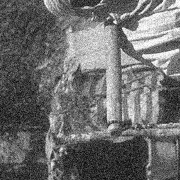

RECONSTRUCTED CLEAN IMAGE


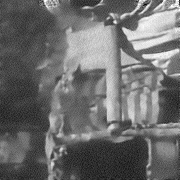

CLEAN IMAGE


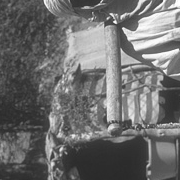

In [ ]:
test_img = 60
T = 50
recorrupted_tensor = generate_recorrupted_tensor(test_images[test_img])
restored_samples = torch.zeros(T, 1, H, W)

for t in range(T):
    model_input = torch.unsqueeze(recorrupted_tensor[t], 0).to(device)
    model_out = torch.squeeze(model(model_input), 0)
    restored_samples[t] = model_out.cpu().detach()
    
model_output = torch.squeeze(torch.mean(restored_samples, 0)).numpy()
model_output = 255.0 * model_output
viewable = model_output.astype(int)
print("NOISY")
orig = cv2_imshow(test_images[test_img].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(ground_truth[test_img].numpy() * 255.0)

### Statistics

In [ ]:
from skimage import metrics

In [ ]:
metrics.peak_signal_noise_ratio(ground_truth[test_img].numpy() * 255.0, model_output, data_range=255)

25.66469017318747

In [ ]:
metrics.structural_similarity(ground_truth[test_img].numpy() * 255.0, model_output)

0.5095937854260159